<a href="https://colab.research.google.com/github/ThatLd/Google_bigquery/blob/main/recommendation_system_on_e_commerce_data_using_BigQuery_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Overview
In this notebook, I build a product recommendation system using matrix factorization (collaborative filtering), and use the predicted results to drive marketing activation.

🎯 to improve **conversions** and **click-through rates**

🎯 to build customer loyalty

BigQuery | [BigQuery ML](https://cloud.google.com/bigquery/docs/bqml-introduction#:~:text=BigQuery%20ML%20democratizes%20machine%20learning,The%20bq%20command%2Dline%20tool) | Google Analytics


## Dataset
[Google Analytics Sample dataset](https://console.cloud.google.com/marketplace/details/obfuscated-ga360-data/obfuscated-ga360-data?filter=solution-type:dataset&project=lyrical-ring-381423) 
It provides 12 months (August 2016 to August 2017) of obfuscated Google Analytics 360 data from the [Google Merchandise Store](https://shop.googlemerchandisestore.com/) , a real ecommerce store that sells Google-branded merchandise, in BigQuery.

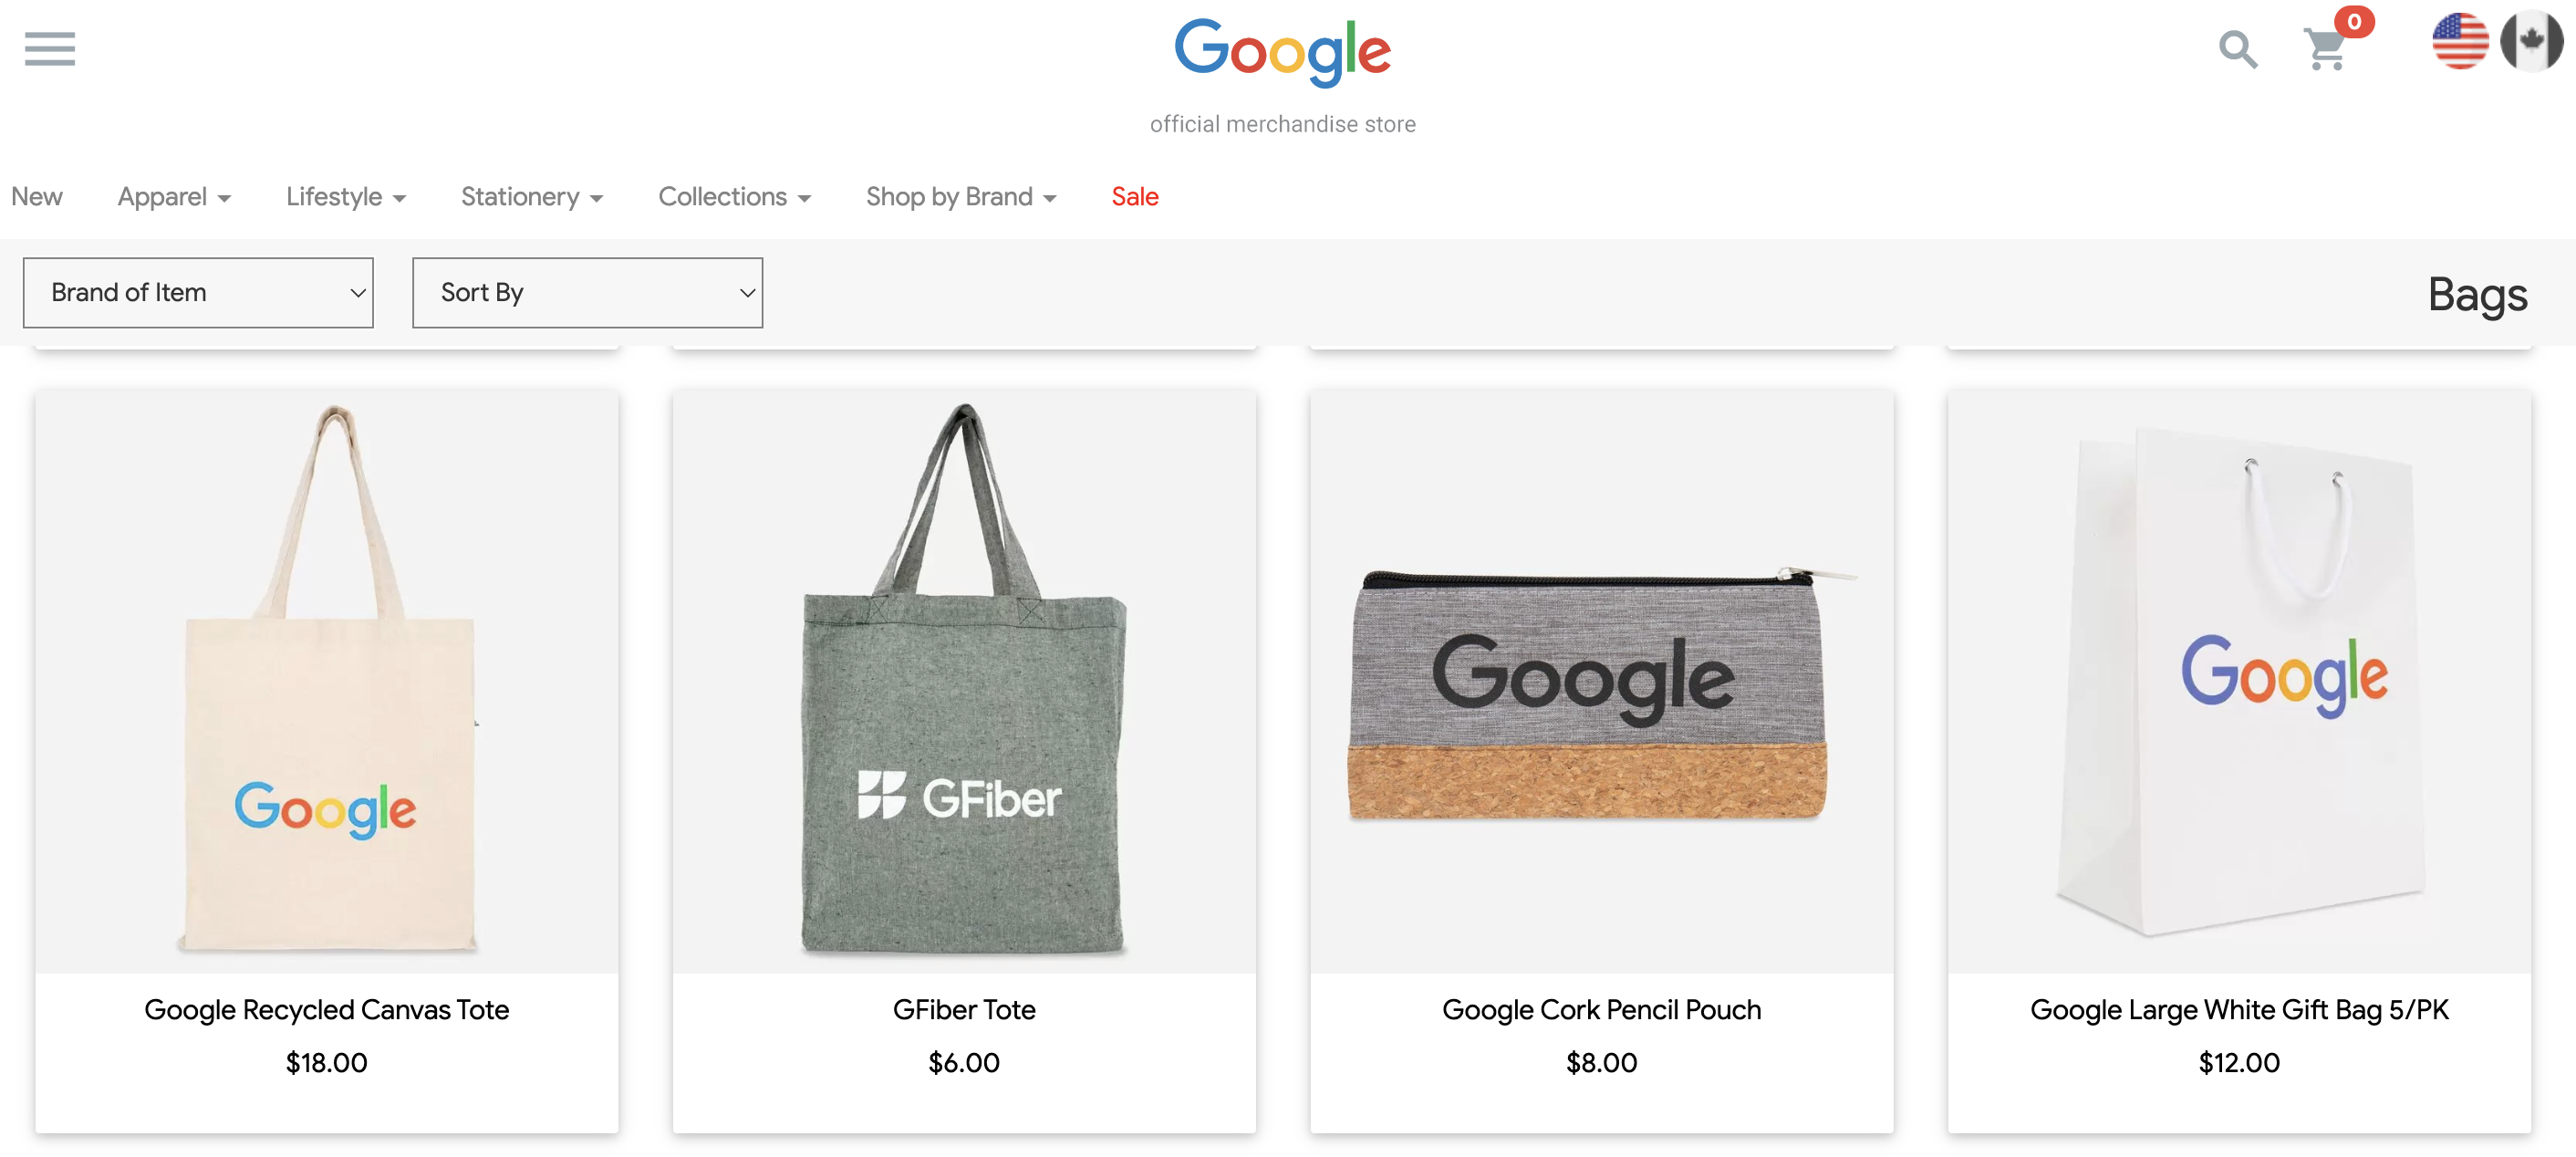

## Objectives
+ data prep-processing
+ train and deploy the model in BigQuery ML
+ model evalutaion
+ prediction
+ take action on the predicted recommendations

##install packages and depeendencies

In [ ]:
!pip install google-cloud-bigquery

In [ ]:
# automatically restart kernel 
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

###set up Google Cloud Platform project
1. [create a GCP project](https://console.cloud.google.com/cloud-resource-manager)
2. make sure the billing is enabled for the project
3. enter project ID and region in the cell below

In [ ]:
# Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

#  make sure cloud SDK uses the right project for all the commands in this notebook
project_id = 'recommendationsystem-383221' # Project ID inserted based on the query results selected to explore
region = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project_id, location=region)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

In [ ]:
!gcloud auth login

###import libraries

In [48]:
from google.cloud import bigquery
import pandas as pd
import time
# define constants
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## process the data
To train the matrix factorization model, I need a table with columns:
+ identify the customer (userId)
+ rated item (itemId)
+ implicit feedback (rating->session duration)


### take a look at the raw data

In [ ]:
%%bigquery --project $project_id
## follows the Google Analytics schema: https://support.google.com/analytics/answer/3437719?hl=en

SELECT 
  CONCAT(fullVisitorID,'-',CAST(visitNumber AS STRING)) AS userId,
  hitNumber,
  time,
  page.pageTitle,
  type,
  productSKU,
  v2ProductName,
  v2ProductCategory,
  productPrice/1000000 as productPrice_USD

FROM 
  `bigquery-public-data.google_analytics_sample.ga_sessions_20160801`, 
  UNNEST(hits) AS hits,
  UNNEST(hits.product) AS hits_product
LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

,userId,hitNumber,time,pageTitle,type,productSKU,v2ProductName,v2ProductCategory,productPrice_USD
0,895954260133011192-1,1,0,Men's-T-Shirts,PAGE,GGOEGAAX0104,Google Men's 100% Cotton Short Sleeve Hero Tee...,Home/Apparel/Men's/Men's-T-Shirts/,16.990
1,895954260133011192-1,1,0,Men's-T-Shirts,PAGE,GGOEGAAX0105,Google Men's 100% Cotton Short Sleeve Hero Tee...,Home/Apparel/Men's/Men's-T-Shirts/,16.990
2,895954260133011192-1,1,0,Men's-T-Shirts,PAGE,GGOEGAAX0107,Google Men's 100% Cotton Short Sleeve Hero Tee...,Home/Apparel/Men's/Men's-T-Shirts/,16.990
3,895954260133011192-1,1,0,Men's-T-Shirts,PAGE,GGOEGAAX0106,Google Men's 100% Cotton Short Sleeve Hero Tee...,Home/Apparel/Men's/Men's-T-Shirts/,16.990
4,895954260133011192-1,1,0,Men's-T-Shirts,PAGE,GGOEGAAX0340,Google Men's Vintage Badge Tee Green,Home/Apparel/Men's/Men's-T-Shirts/,16.990


###create training data

In [ ]:
# create a dataset named(ID) bqml
!bq mk --location=$region --dataset $project_id:bqml

I0427 22:19:00.430488 140241765488448 bigquery_client.py:730] There is no apilog flag so non-critical logging is disabled.
Dataset 'recommendationsystem-383221:bqml' successfully created.


With collaborative filtering (matrix factorization), the dataset must indicate a user's preference for a product, like a rating between 1 and 5 stars. However, in the retail industry, there is usually no or insufficient explicit feedback on how much a user liked a product. Thus, other behavioral metrics need to be used to infer their implicit "rating". 

Here, I look at the total time spent on a product detail page, `session duration`, to infer user interest in a product. So essentially , the more time they spend viewing the product, the higher the implicit rating.


| userId | itemId | session_duration |  
|:---------:|:------:|:----------------:|
|     895954260133011192-1     |   GGOEGAAX0104  |        60        |
|     895954260133011192-1     |  GGOEGAAX0106  |        200       |
|     895954260133011192-2     | GGOEGAAX0104 |       5000       |


The query below will pre-process the data by calculating the total pageview duration per product per user, and materialize the data in a new table, `aggregate_web_stats`.



In [ ]:
# create a table containing training data
%%bigquery --project $project_id

CREATE or REPLACE TABLE bqml.aggregate_web_stats AS (
WITH
  durations 
  AS (
  SELECT
    CONCAT(fullVisitorID, '-', CAST(visitNumber AS STRING), '-', CAST(hitNumber AS STRING)) AS visitorId_session_hit,
    LEAD(time, 1) OVER (
    PARTITION BY CONCAT(fullVisitorID,'-',CAST(visitNumber AS STRING))
    ORDER BY time ASC) - time AS pageview_duration
  FROM `bigquery-public-data.google_analytics_sample.ga_sessions_2016*`, UNNEST(hits) AS hit
  ),

  prodview_durations 
  AS (
      --filter for product detail pages only
  SELECT
    CONCAT(fullVisitorID,'-',CAST(visitNumber AS STRING)) AS userId, productSKU AS itemId, IFNULL(dur.pageview_duration,1) AS pageview_duration,
  FROM `bigquery-public-data.google_analytics_sample.ga_sessions_2016*` t, UNNEST(hits) AS hits, UNNEST(hits.product) AS hits_product
  JOIN 
  durations AS dur
  ON
  CONCAT(fullVisitorID, '-', CAST(visitNumber AS STRING), '-', CAST(hitNumber AS STRING)) = dur.visitorId_session_hit
  WHERE eCommerceAction.action_type = "2"
  ),

  aggregate_web_stats 
  AS(
    --sum pageview durations by userId, itemId
    SELECT userId, itemId, SUM(pageview_duration) AS session_duration
    FROM prodview_durations
    GROUP BY userId,itemId
    )
    
  SELECT * FROM aggregate_web_stats
);
 

Query is running:   0%|          |

""


In [ ]:
%%bigquery --project $project_id
-- Show table
SELECT * FROM bqml.aggregate_web_stats LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,userId,itemId,session_duration
0,5921955043410577506-1,GGOEGAAX0031,13798
1,025812849323675742-1,GGOEGAAX0031,15475
2,1101643307906110582-1,GGOEGAAX0031,471436
3,4830211069912792009-3,GGOEGAAX0031,9701
4,7656818278932400574-1,GGOEGAAX0031,14552
5,7671910071094815906-2,GGOEGAAX0031,16396
6,736530517502037610-1,GGOEGAAX0031,8704
7,4063594254522767136-3,GGOEGAAX0031,7574
8,4913801338365738862-128,GGOEGAAX0031,1234
9,9179931553597212425-1,GGOEGAAX0031,533


### scaling the rating field to [0,1]

We expect that visitors who spent more time on a product like it more. However, the session durations can be a little ridiculous. Notice the 471436 seconds (130 hours) that row #3 shows. We can plot the histogram of session durations in the dataset.

In [40]:
%%bigquery df_train --project $project_id
SELECT * FROM bqml.aggregate_web_stats

Query is running:   0%|          |

Downloading:   0%|          |

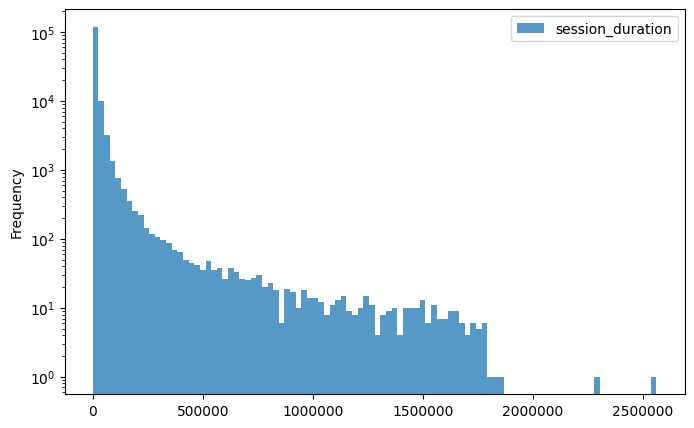

In [52]:
ax = df_train[['session_duration']].plot.hist(bins=100, logy=True, alpha=0.75,figsize=[8,5])
ax.get_xaxis().get_major_formatter().set_scientific(False)

+ scale and clip it the values by the median session duration (average duration 
will be dramatically affected by the outliers)

In [ ]:
%%bigquery --project $project_id
CREATE TEMPORARY FUNCTION CLIP_LESS(x FLOAT64, a FLOAT64) AS (
  IF (x < a, a, x)
);
CREATE TEMPORARY FUNCTION CLIP_GT(x FLOAT64, b FLOAT64) AS (
  IF (x > b, b, x)
);
CREATE TEMPORARY FUNCTION CLIP(x FLOAT64, a FLOAT64, b FLOAT64) AS (
  CLIP_GT(CLIP_LESS(x, a), b)
);

CREATE or REPLACE TABLE bqml.aggregate_web_stats_normalized AS (
WITH
  durations 
  AS (
  SELECT
    CONCAT(fullVisitorID, '-', CAST(visitNumber AS STRING), '-', CAST(hitNumber AS STRING)) AS visitorId_session_hit,
    LEAD(time, 1) OVER (
    PARTITION BY CONCAT(fullVisitorID,'-',CAST(visitNumber AS STRING))
    ORDER BY time ASC) - time AS pageview_duration
  FROM `bigquery-public-data.google_analytics_sample.ga_sessions_2016*`, UNNEST(hits) AS hit
  ),

  prodview_durations 
  AS (
      --filter for product detail pages only
  SELECT
    CONCAT(fullVisitorID,'-',CAST(visitNumber AS STRING)) AS userId, productSKU AS itemId, IFNULL(dur.pageview_duration,1) AS pageview_duration,
  FROM `bigquery-public-data.google_analytics_sample.ga_sessions_2016*` t, UNNEST(hits) AS hits, UNNEST(hits.product) AS hits_product
  JOIN 
  durations AS dur
  ON
  CONCAT(fullVisitorID, '-', CAST(visitNumber AS STRING), '-', CAST(hitNumber AS STRING)) = dur.visitorId_session_hit
  WHERE eCommerceAction.action_type = "2"
  ),

  aggregate_web_stats AS(
    --sum pageview durations by userId, itemId
    SELECT userId, itemId, SUM(pageview_duration) AS session_duration
    FROM prodview_durations
    GROUP BY userId,itemId
    ),

  normalized_session_duration AS (
    SELECT APPROX_QUANTILES(session_duration,100)[OFFSET(50)] AS median_duration
    FROM aggregate_web_stats
)  
  --SELECT * FROM aggregate_web_stats
  SELECT
   * EXCEPT(session_duration, median_duration),
   CLIP(0.3 * session_duration / median_duration, 0, 1.0) AS normalized_session_duration
  FROM
   aggregate_web_stats, normalized_session_duration
);



Query is running:   0%|          |

""


In [53]:
%%bigquery df_train_normalized --project $project_id
SELECT * FROM bqml.aggregate_web_stats_normalized

Query is running:   0%|          |

Downloading:   0%|          |

<Axes: ylabel='Frequency'>

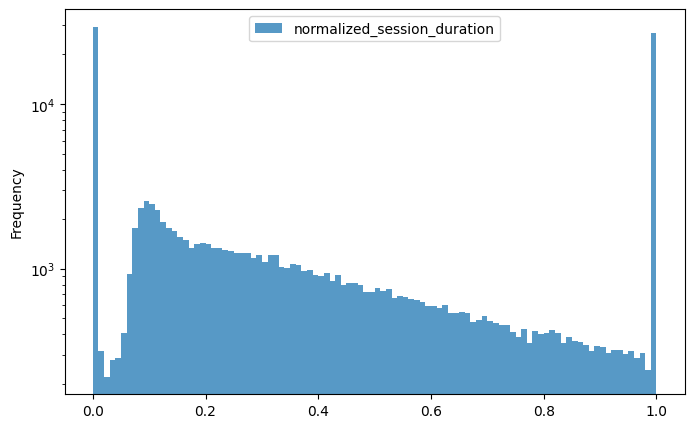

In [54]:
df_train_normalized[['normalized_session_duration']].plot(kind='hist',logy=True,alpha=0.75, bins=100,figsize=[8,5])

## train the matrix factorization model

The table data now looks like this:


In [55]:
%%bigquery --project $project_id
SELECT * FROM bqml.aggregate_web_stats_normalized LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,userId,itemId,normalized_session_duration
0,081985686030532619-3,GGOEGAAX0031,0.190
1,7364014146784677492-1,GGOEGAAX0031,0.161
2,5818856850136424865-1,GGOEGAAX0031,0.892
3,2909077576129053663-1,GGOEGAAX0031,0.522
4,5017352267517896224-6,GGOEGAAX0031,0.522
5,6914566976064854198-1,GGOEGAAX0031,0.238
6,7354873653594141090-1,GGOEGAAX0031,0.194
7,4835082938415020542-3,GGOEGAAX0031,0.353
8,0156363261155251510-1,GGOEGAAX0031,0.617
9,2124657690107685656-2,GGOEGAAX0031,0.420



refer the [CREATE MODEL](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-matrix-factorization) SQL statement to create, train and deploy the matrix factorization model.

*need to set up a reservation (flex or regular) based on [instructions in BigQuery public docs](https://cloud.google.com/bigquery/docs/reservations-workload-management#getting-started-with-bigquery-reservations).*







In [65]:
%%bigquery --project $project_id
CREATE OR REPLACE MODEL
bqml.recommendation_model
OPTIONS(MODEL_TYPE = 'MATRIX_FACTORIZATION',
        FEEDBACK_TYPE = 'IMPLICIT',
        USER_COL = 'userId',
        ITEM_COL = 'itemId',
        RATING_COL = 'normalized_session_duration',
        L2_REG = 30
        )
AS 
SELECT * FROM bqml.aggregate_web_stats_normalized

Query is running:   0%|          |

""


## model evaluation

The training is completed, our model `bqml.recommendation_model` is now deployed! 

See more informaion on model evaluation metrics [here](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-evaluate).



In [66]:
%%bigquery --project $project_id 
SELECT * FROM ML.TRAINING_INFO(MODEL bqml.recommendation_model)

Query is running:   0%|          |

Downloading:   0%|          |

,training_run,iteration,loss,eval_loss,duration_ms
0,0,5,0.028,NaN,28125
1,0,4,0.029,NaN,19154
2,0,3,0.032,NaN,27804
3,0,2,0.056,NaN,18539
4,0,1,0.069,NaN,27796
5,0,0,13.791,NaN,40421


In [67]:
%%bigquery --project $project_id
select mean_squared_error, mean_average_precision, average_rank, normalized_discounted_cumulative_gain from ML.EVALUATE(MODEL bqml.recommendation_model)

Query is running:   0%|          |

Downloading:   0%|          |

,mean_squared_error,mean_average_precision,average_rank,normalized_discounted_cumulative_gain
0,0.017,0.420,0.215,0.914


## hyperparameter tuning


*   L2_REG
*   WALS_ALPHA
*   NUM_FACTORS


## prediction

+ use the model to predict ratings and make recommendations

In [68]:
%%bigquery --project $project_id
# find the ratings for all user-item pairs and save the results to table
CREATE OR REPLACE TABLE bqml.recommend_results
options () as
SELECT * FROM ML.RECOMMEND(MODEL bqml.recommendation_model)

Query is running:   0%|          |

""


+ we can export export the data into a Pandas dataframe using the `%%bigquery <variable name>` 

In [69]:
%%bigquery df --project $project_id
SELECT * FROM bqml.recommend_results

Query is running:   0%|          |

Downloading:   0%|          |

In [70]:
df.head()

,predicted_normalized_session_duration_confidence,userId,itemId
0,0.168,9559994328183410807-1,GGOEGAAX0594
1,0.002,6896874006518707059-1,GGOEGAAX0655
2,0.027,8867390072588878980-1,GGOEGAAX0616
3,0.172,7435052038545127483-4,GGOEGOAR021899
4,-0.015,5210730589412232937-1,GGOEGOAB021699


+ top 5 products I could recommend to a user '8173388962245475850-1'

In [73]:
%%bigquery --project $project_id
SELECT userId, itemId, predicted_normalized_session_duration_confidence FROM bqml.recommend_results 
where userID='8173388962245475850-1' and predicted_normalized_session_duration_confidence < 1
ORDER BY predicted_normalized_session_duration_confidence DESC
LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

,userId,itemId,predicted_normalized_session_duration_confidence
0,8173388962245475850-1,GGOEGHPA002910,0.772
1,8173388962245475850-1,GGOEGAAX0031,0.725
2,8173388962245475850-1,GGOEGHPB003410,0.645
3,8173388962245475850-1,GGOEGAAX0331,0.563
4,8173388962245475850-1,GGOEYHPB072210,0.550


+ the names of the 5 recommended products

In [75]:
%%bigquery --project $project_id
WITH product_details AS(
    SELECT 
        productSKU,
        v2ProductName,
    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_2016*`,
        UNNEST(hits) AS hits,
        UNNEST(hits.product) AS hits_product
    GROUP BY 2,1 
)

SELECT
  r.userId, r.itemId, r.predicted_normalized_session_duration_confidence,
  pd.v2ProductName
FROM 
(SELECT * FROM bqml.recommend_results where userID='8173388962245475850-1' and predicted_normalized_session_duration_confidence < 1) r
JOIN
  product_details pd
ON
  r.itemId = pd.productSKU
ORDER BY predicted_normalized_session_duration_confidence DESC
LIMIT 5 


Query is running:   0%|          |

Downloading:   0%|          |

,userId,itemId,predicted_normalized_session_duration_confidence,v2ProductName
0,8173388962245475850-1,GGOEGHPA002910,0.772,Google Trucker Hat
1,8173388962245475850-1,GGOEGAAX0031,0.725,Google Stretch Fit Hat
2,8173388962245475850-1,GGOEGHPB003410,0.645,Google Snapback Hat Black
3,8173388962245475850-1,GGOEGAAX0331,0.563,Google Long Sleeve Raglan Badge Henley Ocean Blue
4,8173388962245475850-1,GGOEGAAX0331,0.563,Google Men's Long Sleeve Raglan Ocean Blue


+ top 3 recommended products for each user

In [93]:
%%bigquery --project $project_id

-- Create output table
CREATE OR REPLACE TABLE bqml.prod_recommendations AS (
WITH predictions AS (
    SELECT 
      userId, 
      ARRAY_AGG(STRUCT(itemId, predicted_normalized_session_duration_confidence)
                ORDER BY predicted_normalized_session_duration_confidence DESC
                LIMIT 3) as recommended
    FROM bqml.recommend_results
    WHERE predicted_normalized_session_duration_confidence<1
    GROUP BY userId
)
    
SELECT
  userId,
  itemId,
  predicted_normalized_session_duration_confidence
FROM
  predictions p,
  UNNEST(recommended)
);

select * from bqml.prod_recommendations order by userId, predicted_normalized_session_duration_confidence desc limit 9;

Query is running:   0%|          |

Downloading:   0%|          |

,userId,itemId,predicted_normalized_session_duration_confidence
0,0000010278554503158-1,GGOEYFKQ020699,0.154
1,0000010278554503158-1,GGOEGAAX0104,0.120
2,0000010278554503158-1,GGOEGFKA022299,0.110
3,0000020424342248747-1,GGOEGBRA037499,0.984
4,0000020424342248747-1,GGOEGBRB073899,0.889
5,0000020424342248747-1,GGOEGBRJ037399,0.681
6,000005103959234087-1,GGOEGCNB021099,0.815
7,000005103959234087-1,GGOEGCMB020932,0.503
8,000005103959234087-1,GGOEGAAX0338,0.480


## take actions on the recommendations
#### plug into production pipeline
+ export recommendations for marketing activations via Google Ads, to generate custom remarketing audiences and target customers more effectively with ads


We need to normalize the confidence scores between 0 and 1 for Google Analytics 360 using [ML.MIN_MAX_SCALER](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-preprocessing-functions#mlmin_max_scaler)

In [ ]:
%%bigquery --project $project_id
WITH predictions AS (
    SELECT 
      userId, 
      ARRAY_AGG(STRUCT(itemId, predicted_session_duration_confidence)
                ORDER BY predicted_session_duration_confidence) as recommended
    FROM bqml.recommend_results
    WHERE itemId = "GGOEGAAX0105"
    GROUP BY userId
)
  
SELECT
  userId,
  ML.MIN_MAX_SCALER(
    predicted_session_duration_confidence
    ) OVER() as GGOEGAAX0105
FROM
  predictions p,
  UNNEST(recommended)
ORDER BY GGOEGAAX0105 DESC

Query is running:   0%|          |

Downloading:   0%|          |

,userId,GGOEGAAX0105
0,0028575549468999503-1,1.000
1,0622037019916158233-1,0.980
2,0154139925435545439-3,0.973
3,556119383802542074-1,0.970
4,3290482216407456011-2,0.956
...,...,...
58526,8766740737091466185-1,0.273
58527,3229944860313764519-2,0.270
58528,1726165891075488090-1,0.209
58529,4417043523182966931-2,0.166


To export to Google Analytics 360 from BigQuery:

Follow the [instructions](https://github.com/google/modem/tree/master/bqml) to build your ETL pipeline from BigQuery ML to Google Analytics using [MoDeM](https://github.com/google/modem). 